In [ ]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from data_tools import process_data as processed
from data_tools.combine_data import CreateTrainingandTestData
from data_tools import process_dates
from data_tools import handle_datetime
from data_tools import clean_data as clean

combine = CreateTrainingandTestData()
# Change as needed
sensor_id = "Fresno"
pmdata = "m_PM25_b"
year = "2023"

data_name = {
    "m_PM25_CF1":{
        "temp": "tempC_pms",
        "rh": "rh_pms",
        "pm1": "m_PM1_CF1",
        "pm2.5": "m_PM25_CF1",
        "pm10": "m_PM10_CF1",
        "name": "Plantower"
    },
    "m_PM25_b":{
        "temp": "tempC_sen5x",
        "rh": "rh_sen5x",
        "pm1": "m_PM1_b",
        "pm2.5": "m_PM25_b",
        "pm10": "m_PM10_b",
        "name": "Sensirion"
    }
}
sensor = data_name[pmdata]
training_dates = process_dates.training(sensor_id)
testing_dates= process_dates.testing(sensor_id)

# Define files that hold necessary raw data
reference_file_1 = rf"../reference_files/PM25HR_PICKDATA_2023-12-31-Fresno.csv"
if sensor_id == "Tranquility":
    reference_file_2 = rf"../reference_files/PM25HR_PICKDATA_2023-12-31-Tranquility.csv"
else:
    reference_file_2 = reference_file_1
sensor_file = rf"../reference_files/2023rawdata/{sensor_id}.csv"
calibration_reference = handle_datetime.utc_to_CA(processed.ref_data(reference_file_1))
deployment_reference = handle_datetime.utc_to_CA(processed.ref_data(reference_file_2))
voz_data = handle_datetime.utc_to_CA(processed.raw_voz_data(sensor_file))

when = {
    "precal_start": training_dates[0],
    "precal_end": training_dates[1],
    "postcal_start": training_dates[2],
    "postcal_end": training_dates[3],
    "trial1_start": testing_dates[0],
    "trial1_end": testing_dates[1],
    "trial2_start": testing_dates[2],
    "trial2_end": testing_dates[3]
}
combine.set_calibration_parameters(pmdata,sensor_id,voz_data)
training_data,all_data = combine.get_combined_data(training_dates,testing_dates,calibration_reference,deployment_reference)
training_data,all_data = map(lambda df: clean.eliminate_waste_data(df, sensor), [training_data, all_data])

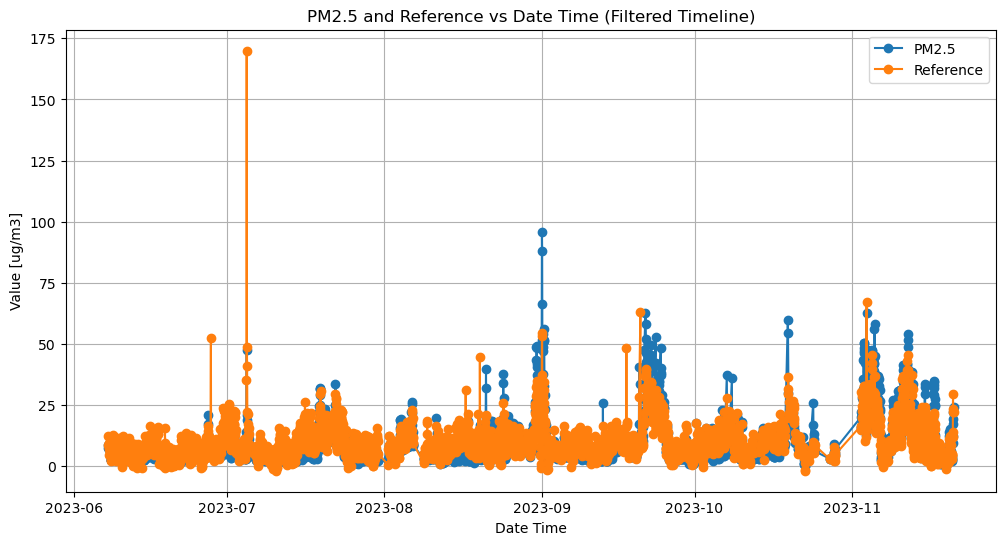

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the start and end dates for the desired timeline
start_date_filter = pd.to_datetime("2023-06-07")
end_date_filter = pd.to_datetime("2023-11-21")

# Apply the date range filter to the merged data
filtered_data = all_data[(all_data.index >= start_date_filter) & (all_data.index <= end_date_filter)]

# Line plot for 'o3' and 'reference' columns against 'date_time' within the specified timeline
plt.figure(figsize=(12, 6))

# Plot 'o3' column
plt.plot(filtered_data.index, filtered_data[sensor["pm2.5"]], label='PM2.5', marker='o')

# Plot 'reference' column
plt.plot(filtered_data.index, filtered_data['reference'], label='Reference', marker='o')

# Customize the plot
plt.title('PM2.5 and Reference vs Date Time (Filtered Timeline)')
plt.xlabel('Date Time')
plt.ylabel('Value [ug/m3]')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
import numpy as np
from data_tools import elastic_net
from data_tools.calibration_formulas.clarity import ClarityCalibrator
# Individual unit remake of Clarity's calibration

clarity = ClarityCalibrator()

training_data = clarity.add_necessary_variables(training_data, sensor)
all_data = clarity.add_necessary_variables(all_data, sensor)

variables = [sensor["pm2.5"],sensor["rh"],sensor["pm1"],'temp_minus_dew_point','pm_rh_interaction']
clarity_output = rf"../reference_files/2023rawdata/{sensor["name"]}_calibration_variables/{sensor_id}ClarityRemake.csv"
new_column = "pm_calibrated_clarityremake"

try:
    calibration_model = elastic_net.calibrate(training_data, variables, clarity_output)
    calibrated_data = elastic_net.apply_calibration(calibration_model,all_data,variables,new_column)
    print("Calibrated data:", calibrated_data[new_column])
except ValueError as e:
    print("Error:", e)


Range '10+' | Coefficients: [ 0.58079356  0.05494794  0.43981971  0.18831896 -0.00461931] | Intercept: -2.4345762879096213
Applied calibration models; results stored in 'pm_calibrated_clarityremake'
Calibrated data: date_time
2023-06-07 15:30:00     8.459003
2023-06-07 16:30:00     9.115840
2023-06-07 17:30:00     9.518230
2023-06-07 18:30:00     8.766163
2023-06-07 19:30:00     7.882104
                         ...    
2023-12-03 11:30:00    16.187938
2023-12-03 12:30:00    15.052067
2023-12-03 13:30:00    15.052756
2023-12-03 14:30:00    13.505104
2023-12-03 15:30:00    17.492911
Name: pm_calibrated_clarityremake, Length: 3422, dtype: float64


In [114]:
#elasticnet regression with 2 variables

variables = [sensor["pm2.5"],sensor["rh"]]
twovar_output = rf"../reference_files/2023rawdata/{sensor["name"]}_calibration_variables/{sensor_id}2Vars.csv"
new_column = "pm_calibrated_twovar"
try:
    calibration_model = elastic_net.calibrate(training_data, variables, twovar_output)
    calibrated_data = elastic_net.apply_calibration(calibration_model,all_data,variables,new_column)
    print("Calibrated data:", calibrated_data[new_column])
except ValueError as e:
    print("Error:", e)



Range '10+' | Coefficients: [ 0.72061082 -0.06746099] | Intercept: 6.1016437155660475
Applied calibration models; results stored in 'pm_calibrated_twovar'
Calibrated data: date_time
2023-06-07 15:30:00     8.507252
2023-06-07 16:30:00     9.085351
2023-06-07 17:30:00     9.513116
2023-06-07 18:30:00     8.804936
2023-06-07 19:30:00     7.937562
                         ...    
2023-12-03 11:30:00    15.718499
2023-12-03 12:30:00    14.722547
2023-12-03 13:30:00    14.700954
2023-12-03 14:30:00    13.244912
2023-12-03 15:30:00    17.039619
Name: pm_calibrated_twovar, Length: 3422, dtype: float64


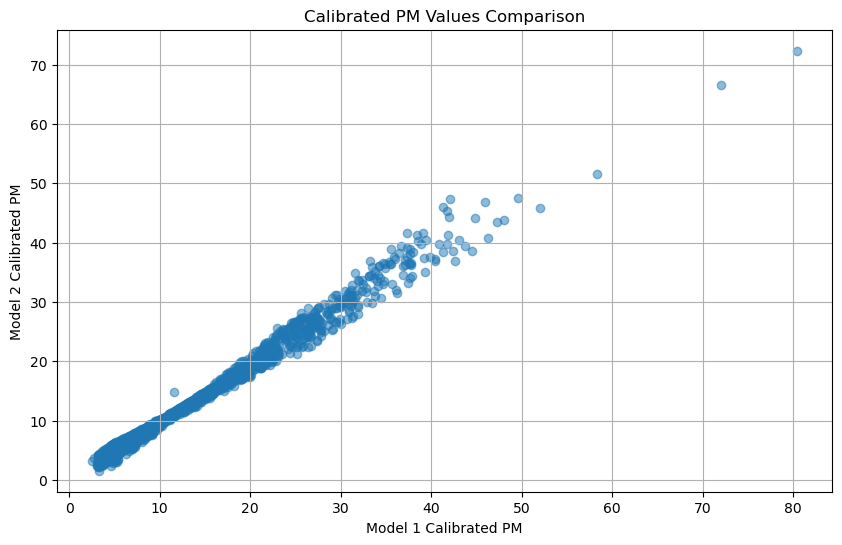

In [115]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(calibrated_data['pm_calibrated_clarityremake'], calibrated_data['pm_calibrated_twovar'], alpha=0.5)
plt.title('Calibrated PM Values Comparison')
plt.xlabel('Model 1 Calibrated PM')
plt.ylabel('Model 2 Calibrated PM')
plt.grid(True)


In [116]:
'''
Universal calibration models for Plantower 
Clarity Calibration Model released on April 23, 2025
Uses variables: rh, temp minus dew (magnus formula), pm rh interaction, pm2.5, pm10, pm1

EPA 2023 Model release mostly for smoke/dust events
Uses variables pm2.5 and rh

Barkjohn EPA 2021 Model 
Uses variables pm2.5 and rh
'''
if sensor["name"] == "Plantower":

    # Clarity's PM6003 Calibration (works well even for 5003)
    calibrated_data = clarity.calibrate(calibrated_data)

    # EPA 2021 Correction (Barkjohn's Formula)
    from data_tools.calibration_formulas import epa_barkjohn
    calibrated_data = epa_barkjohn.calibrate(calibrated_data)


In [117]:
calibrated_file = rf"../reference_files/2023{sensor["name"]}DataCalibrated/{sensor_id}_calibrated.csv"
calibrated_data.to_csv(calibrated_file, index=True)

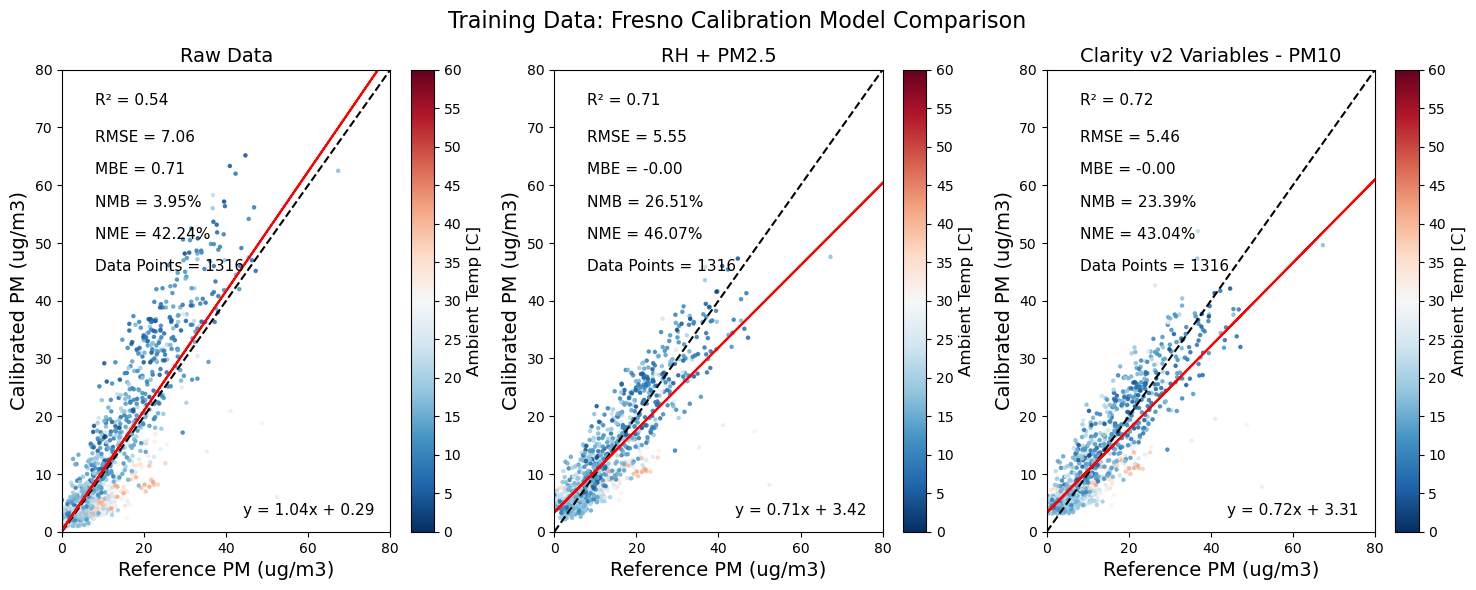

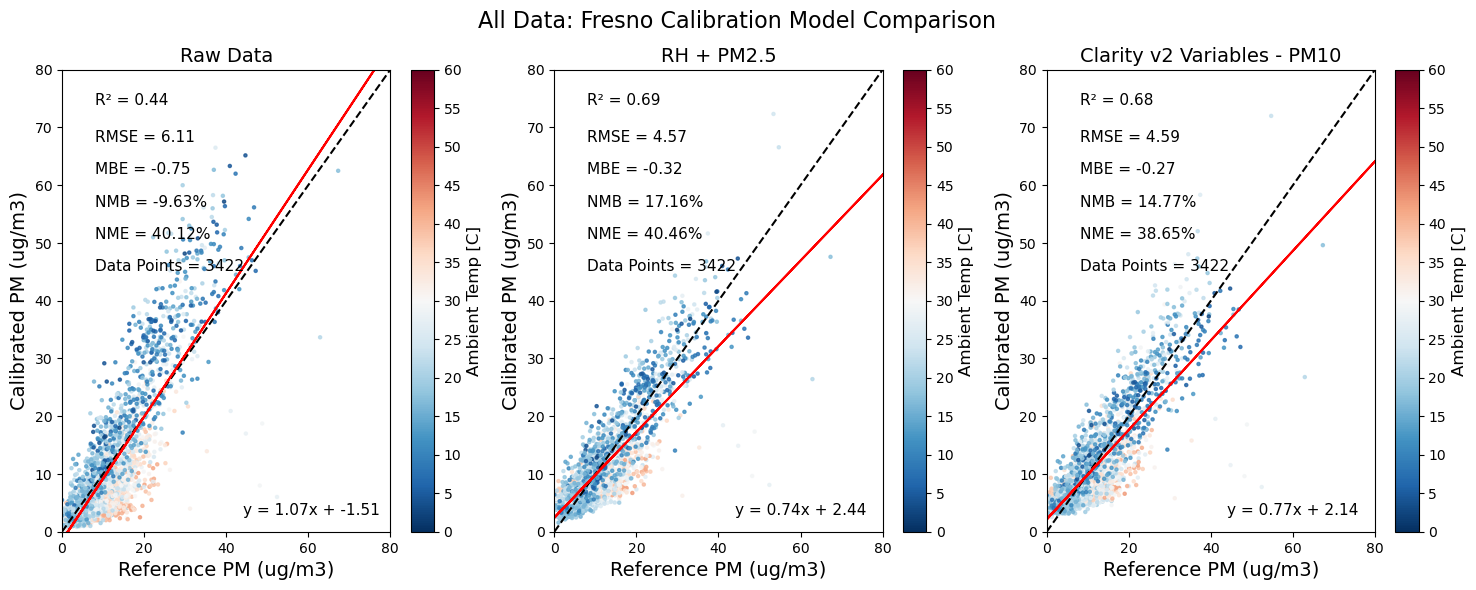

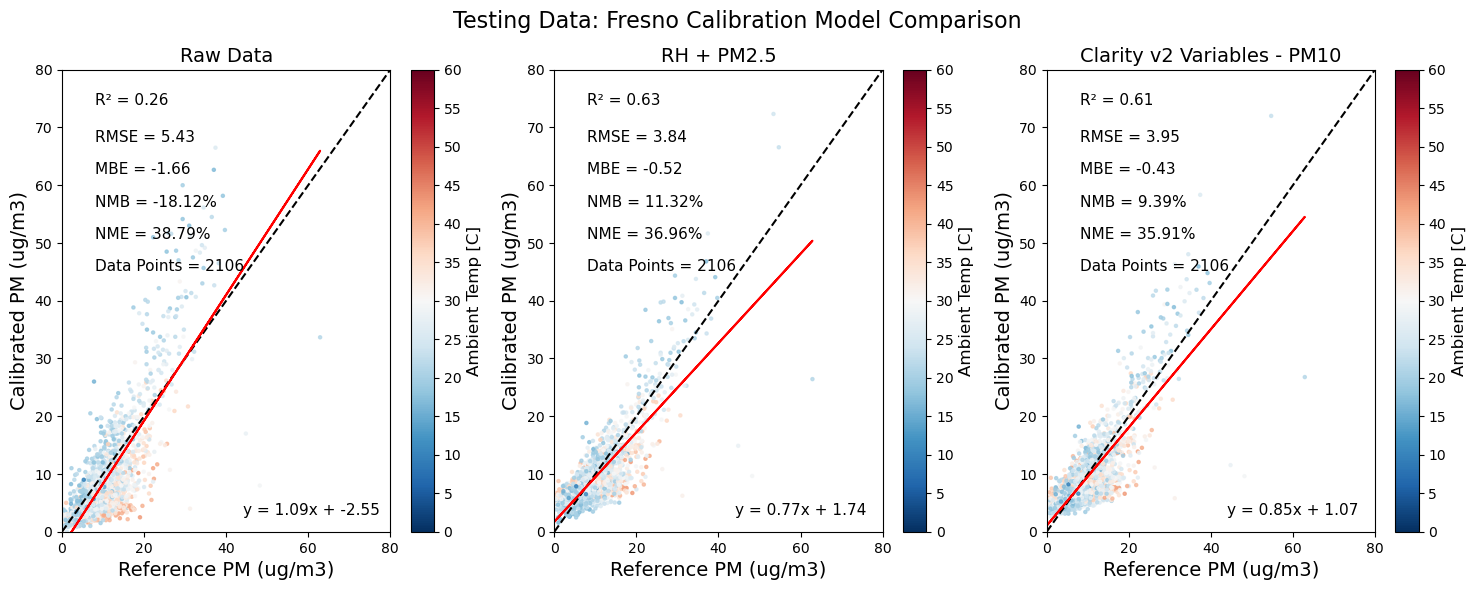

In [118]:
from data_tools.plot_against_reference import PlotPlantower
from data_tools.plot_against_reference import PlotSensirion
ps = PlotSensirion()
ptw = PlotPlantower()

training_data = combine.subsection(all_data,training_dates)
testing_data = combine.subsection(all_data,testing_dates)
# Base columns to always drop NAs for
dropna_cols = [
    'reference',
    sensor["pm2.5"],
    'pm_calibrated_twovar',
    'pm_calibrated_clarityremake'
]

# Conditionally add EPA columns
if sensor["name"] == "Plantower":
    dropna_cols += [
        'pm_calibrated_clarity','pm_calibrated_epa_barkjohn'
    ]

if(sensor["name"] == "Plantower"):
    ptw.plot(training_data,sensor_id,"Training")
    ptw.plot(all_data,sensor_id,"All")
    ptw.plot(testing_data,sensor_id,"Testing")
else:
    ps.plot(training_data,sensor_id,"Training")
    ps.plot(all_data,sensor_id,"All")
    ps.plot(testing_data,sensor_id,"Testing")

In [119]:
# import matplotlib.dates as mdates
# from scipy import stats
# import numpy as np

# # Line plot for 'o3' and 'reference' columns against 'date_time' within the specified timeline
# plt.figure(figsize=(8, 12))

# start_date = pd.to_datetime("2023-08-14")
# end_date = pd.to_datetime("2023-12-16")

# merged_data_yearround = pd.concat([precal_merged, trial1_merged, trial2_merged, postcal_merged])

# # Drop rows with missing values in the columns of interest
# merged_data_yearround.dropna(subset=['reference', 'PM_calibrated_Basic', 'PM_calibrated_ClarityRemake', 'm_PM25_CF1', 'PM_calibrated_EPA_Piecewise', 'PM_calibrated_EPA_Barkjohn', 'PM_calibrated_Clarity'], inplace=True)

# merged_data_yearround['ratio'] = merged_data_yearround['PM_calibrated_ClarityRemake']/merged_data_yearround['reference']

# merged_data_yearround_filtered = merged_data_yearround.loc[start_date:end_date]

# merged_data_yearround_filtered['day_counter'] = (
#     (merged_data_yearround_filtered.index - merged_data_yearround_filtered.index[0])
#     / pd.Timedelta(days=1)
# )
# x = merged_data_yearround_filtered['day_counter']
# y = merged_data_yearround_filtered['ratio']

# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# y_fit = slope * x + intercept
# print(x)
# fig, ax = plt.subplots()

# # Plot 'o3' column
# plt.plot(x, y, marker='o', color='orange', label="ratio")
# plt.hlines(y=1, xmin=merged_data_yearround_filtered['day_counter'][0], xmax=merged_data_yearround_filtered['day_counter'][len(merged_data_yearround_filtered)-1], color='green', linestyle='-', label="Y = 1")
# # Customize the plot
# plt.title('CCEJN AQLite Validated Against CARB Monitor')
# plt.xlabel('Date')
# plt.ylabel('AQLite Ozone over Reference Ozone')
# plt.ylim(0, 15)
# plt.legend()
# plt.grid(True)

# # Set major ticks to the first of each month
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# # # Optional: minor ticks for better granularity
# # ax.xaxis.set_minor_locator(mdates.DayLocator())  # Mondays
# # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# # Improve label spacing
# fig.autofmt_xdate()

# plt.show()

In [120]:
# # === Optionally filter by date range ===
# start_date = pd.to_datetime("2023-06-09")
# end_date = pd.to_datetime("2023-06-15")

# calibrated_data_filtered = calibrated_data[(calibrated_data.index >= start_date) & (calibrated_data.index <= end_date)]
# ref_filtered = reference_data[(reference_data.index >= start_date) & (reference_data.index <= end_date)]

# # === Plotting ===
# plt.figure(figsize=(12, 6))

# # Plot CSV data
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_Clarity'], label='Clarity Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_ClarityRemake'], label='Clarity Remake Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_EPA_Piecewise'], label='EPA 2023 Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_EPA_Barkjohn'], label='EPA 2021 Calibration', marker='o')

# # Plot reference data
# plt.plot(ref_filtered.index, ref_filtered['reference'], label='Reference Data', marker='x')

# plt.title(f'{sensor_id} VOZbox vs. FEM')
# plt.xlabel('Date')
# plt.ylabel('PM [ug/m3]')
# plt.ylim(0, 30)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# # plt.savefig(rf"./images/{sensor_id}CalibratedGraph.jpg", format='jpg', dpi=300)
# # plt.show()

In [121]:
# import requests
# import pandas as pd

# API_KEY = "C776CB92-8D28-11F0-BDE5-4201AC1DC121"

# # Central Valley bounding box (rough example)
# # lat_min, lat_max, lon_min, lon_max

# lat_min, lat_max = 35.491750, 36.813374
# lon_min, lon_max = -120.501901, -118.897490

# url = "https://api.purpleair.com/v1/sensors"

# params = {
#     "fields": "latitude,longitude,pm2.5,temperature,humidity",
#     "location_type": 0,  # outside only
#     "nwlng": lon_min,
#     "nwlat": lat_max,
#     "selng": lon_max,
#     "selat": lat_min
# }

# headers = {"X-API-Key": API_KEY}

# resp = requests.get(url, params=params, headers=headers).json()

# # Convert to DataFrame
# sensors = pd.DataFrame(resp["data"], columns=resp["fields"])
# sensors.to_csv("central_valley_purpleair_sensors.csv", index=False)
# print(sensors)